In [2]:
# 
# calculate the advection-diffusion equation
# using simpliest first-order numerical method

import numpy as np
import math

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker, cm

import scipy
from scipy import interpolate
from scipy.sparse import diags
import scipy.sparse as sp

from tqdm import tqdm 


# constant variables
PI = 3.14159

# time step
Dt = 40 # [s]

# grid resolution
Dx = 100 # [m]
Dy = 10 # [m]

# grid number
Nx = 1000 # 2000 # 75
Ny = 120 # 240 # 30

i_init = round(Nx/2)
j_init = round(Ny/2)
print('center:',i_init,j_init)

x = []
for i in range(Nx):
    x.append((i-i_init)*Dx)
    
y = []
for j in range(Ny):
    y.append((j-j_init)*Dy)

X, Y = np.meshgrid(x, y)

# define diffusion coefficient
Diff_x  = 10.0 # 15 # 5 #  [m2 s-1]
Diff_y  = 0.15 # 0.2 # 0.1 # [m2 s-1]
U_shear = 0.002 # 0.003 # 0.001 # [s-1]

center: 500 60


In [3]:
print( np.tan(2/180*PI) )

0.034920739971461764


U.shape: (120, 1000)


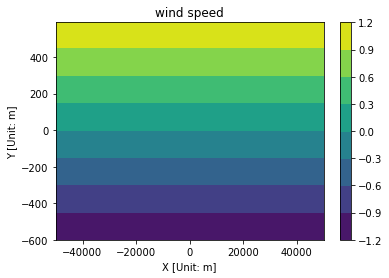

In [4]:
# define a fixed wind field


V = np.zeros([Ny,Nx]) # [m]
U = np.zeros([Ny,Nx])
print('U.shape:',U.shape)

for j in range(Ny):
    U[j,:] = Y[j,:] * U_shear # [m]
    
plt.contourf(X,Y,U)
plt.colorbar()
plt.xlabel('X [Unit: m]')
plt.ylabel('Y [Unit: m]')
plt.title( 'wind speed' )
plt.show()


100000000.0


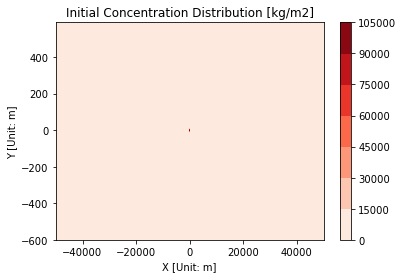

In [5]:
# define initial concentration distribution

C0_gau = np.zeros([Ny,Nx])

Mass = 1.0e+8 # [kg]
C0_gau[j_init,i_init] = Mass/(Dx*Dy) # [kg m-2]
# Concnt[j_init,i_init] = Concnt[j_init,i_init] / 1.0e+6 / 98.0 * AVO

Original = C0_gau[j_init,i_init]*Dx*Dy
print(Original)

contours = plt.contourf(X, Y, C0_gau, cmap='Reds')
plt.xlabel('X [Unit: m]')
plt.ylabel('Y [Unit: m]')
plt.title( 'Initial Concentration Distribution [kg/m2]' )
plt.colorbar()


plt.show()

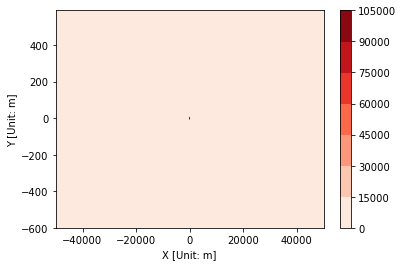

In [6]:
# define initial concentration distribution
Concnt = np.zeros([Ny,Nx])
C_old  = np.zeros([Ny,Nx])

#Concnt[j_init-2:j_init+3,i_init-2:i_init+3] = 1000.0 # [molec m2]
Concnt = C0_gau # [molec m2]

contours = plt.contourf(X, Y, Concnt, cmap='Reds')
plt.xlabel('X [Unit: m]')
plt.ylabel('Y [Unit: m]')
# plt.title( 'Initial Concentration [kg/m2], time='+str(t0/3600)+' h' )
plt.colorbar()

plt.show()

In [7]:
def Adv_Diff(C, U, Diff_x, Diff_y, Dt, Dx, Dy, Nx, Ny):
    C_new = C*0.0
    
    for j in range(1,Ny-1,1):
        for i in range(1,Nx-1,1):
            alpha = Dt*U[j,i]/Dx
            C_new[j,i] = C[j,i] - 0.5*alpha*(C[j,i+1]-C[j,i-1]) \
                            + 0.5*alpha**2*(C[j,i+1]-2*C[j,i]+C[j,i-1]) \
                       + Dt*(Diff_x*(C[j,i-1]+C[j,i+1]-2*C[j,i])/(Dx*Dx) \
                             + Diff_y*(C[j-1,i]+C[j+1,i]-2*C[j,i])/(Dy*Dy) )
    
    return C_new

In [8]:
def Get_XYscale(Concnt, Dx, Dy, Nx, Ny, frac):
    
    M2d = Concnt*Dx*Dy
    total_mass = np.sum(M2d, axis=(0,1))
    
    Ysum = np.sum(M2d,axis=1) # sum along x axis
    Ysum_sort = sorted(Ysum, reverse=True)
    Ysum_cum = np.cumsum(Ysum_sort)
    numY = abs(Ysum_cum - frac*total_mass).argmin()
    Yscale = numY*Dy
    
    Xsum = np.sum(M2d,axis=0) # sum along x axis
    Xsum_sort = sorted(Xsum, reverse=True)
    Xsum_cum = np.cumsum(Xsum_sort)
    numX = abs(Xsum_cum - frac*total_mass).argmin()
    Xscale = numX*Dx
    
    return Xscale, Yscale

In [9]:
# Lax–Wendroff Scheme

def Adv_Diff2(C, U, Diff_x, Diff_y, Dt, Dx, Dy, Nx, Ny):
    C_new = C*0.0
    C2    = C*0.0

    
    alpha = Dt*U[:,1:i-1]/Dx
    C2[:,1:i-1] = C[:,1:i-1] - 0.5*alpha*(C[:,2:i]-C[:,0:i-2]) \
                          + 0.5*alpha**2*(C[:,2:i]-2*C[:,1:i-1]+C[:,0:i-2])
    
#     for j in range(0,Ny,1):
#         alpha = Dt*U[j,1]/Dx
#         C2[j,1:i-1] = C[j,1:i-1] - 0.5*alpha*(C[j,2:i]-C[j,0:i-2]) \
#                             + 0.5*alpha**2*(C[j,2:i]-2*C[j,1:i-1]+C[j,0:i-2])
     
    
    C_new[1:j-1,1:i-1] = C2[1:j-1,1:i-1] + Dt*(Diff_x*(C2[1:j-1,0:i-2]+C2[1:j-1,2:i]-2*C2[1:j-1,1:i-1])/(Dx*Dx) \
                                             + Diff_y*(C2[0:j-2,1:i-1]+C2[2:j,1:i-1]-2*C2[1:j-1,1:i-1])/(Dy*Dy) )
    
    return C_new

In [10]:
# Test confusion CFL condition
if 2*Diff_y*Dt/(Dy**2)>1:
    print('****************************************')
    print('WARNING: Y: CFL condition is not satisfied')
    print('Try to increase Dy or decrease Dt')
    print('****************************************')
    
if 2*Diff_x*Dt/(Dx**2)>1:
    print('****************************************')
    print('WARNING: X: CFL condition is not satisfied')
    print('Try to increase Dx or decrease Dt')
    print('****************************************')
    
# Test advective CFL condition
if np.max(U)*Dt/Dx>1:
    print('****************************************')
    print('WARNING: X: CFL condition is not satisfied')
    print('Try to increase Dx or decrease Dt')
    print('****************************************')

    contours = plt.contourf(X,Y,Concnt)
#    plt.clabel(contours, inline=True, fontsize=8)
    plt.show()

In [11]:
%%time

# time run
Nt           = int(3600*12/Dt)

# Judge_radian = (90-2)/180*PI # [radians]
scale_ratio  = 25

Theta        = 0.0           # [radians]
Height       = 0.0           #[m]

for t in tqdm(range(Nt)):    
    Concnt = Adv_Diff2(Concnt, U, Diff_x, Diff_y, Dt, Dx, Dy, Nx, Ny)
       
    frac = 0.9
    Xscale, Yscale = Get_XYscale(Concnt, Dx, Dy, Nx, Ny, frac)
    Theta = math.atan(Xscale/Yscale)
    
    if Xscale/Yscale>scale_ratio:
        print(t*Dt/3600)
        break 

  0%|          | 0/1080 [00:00<?, ?it/s]<timed exec>:15: RuntimeWarning: invalid value encountered in long_scalars
<timed exec>:17: RuntimeWarning: invalid value encountered in long_scalars
 46%|████▌     | 495/1080 [00:04<00:05, 106.83it/s]

5.5
CPU times: user 2.92 s, sys: 1.73 s, total: 4.66 s
Wall time: 4.67 s


In [12]:
Xscale, Yscale

(6100, 240)

In [13]:
t0 = (t+1)*Dt  # initial time for 1-D grids
t0/3600

5.511111111111111

In [14]:
np.tan((88)/180*PI)

28.635188185101054

In [15]:
# sensitive test

# time run
Nt = int(3600*24/Dt)
time = t0+Nt*Dt

C1_center = []
C2_center = []
C3_center = []
C4_center = []


Concnt1 = Concnt
Diff2_x = Diff_x # [m2 s-1]
Diff2_y = Diff_y # [m2 s-1]
for t in tqdm(range(Nt)):   
    Concnt1 = Adv_Diff2(Concnt1, U, Diff_x, Diff_y, Dt, Dx, Dy, Nx, Ny)
    if Nt*Dt%3600==0:
        C1_center.append(np.max(Concnt1))

        
# Concnt2 = Concnt   
# Diff2_x = Diff_x # [m2 s-1]
# Diff2_y = 0.0 # [m2 s-1]
# for t in tqdm(range(Nt)):
#     Concnt2 = Adv_Diff2(Concnt2, U, Diff2_x, Diff2_y, Dt, Dx, Dy, Nx, Ny)
#     if Nt*Dt%3600==0:
#         C2_center.append(np.max(Concnt2))
    
    
Concnt3 = Concnt   
Diff3_x = 0.0 # [m2 s-1]
Diff3_y = Diff_y # [m2 s-1]
for t in tqdm(range(Nt)):
    Concnt3 = Adv_Diff2(Concnt3, U, Diff3_x, Diff3_y, Dt, Dx, Dy, Nx, Ny)
    if Nt*Dt%3600==0:
        C3_center.append(np.max(Concnt3))    
    
    
# Concnt4 = Concnt   
# Diff4_x = 0.0 # [m2 s-1]
# Diff4_y = 0.0 # [m2 s-1]
# for t in tqdm(range(Nt)):
#     Concnt4 = Adv_Diff2(Concnt4, U, Diff4_x, Diff4_y, Dt, Dx, Dy, Nx, Ny)
#     if Nt*Dt%3600==0:
#         C4_center.append(np.max(Concnt4))

100%|██████████| 2160/2160 [00:16<00:00, 131.44it/s]


In [16]:
frac = 0.9
Xscale1, Yscale1 = Get_XYscale(Concnt1, Dx, Dy, Nx, Ny, frac)
Theta1 = math.atan(Xscale1/Yscale1)

In [17]:
X.shape


(120, 1000)

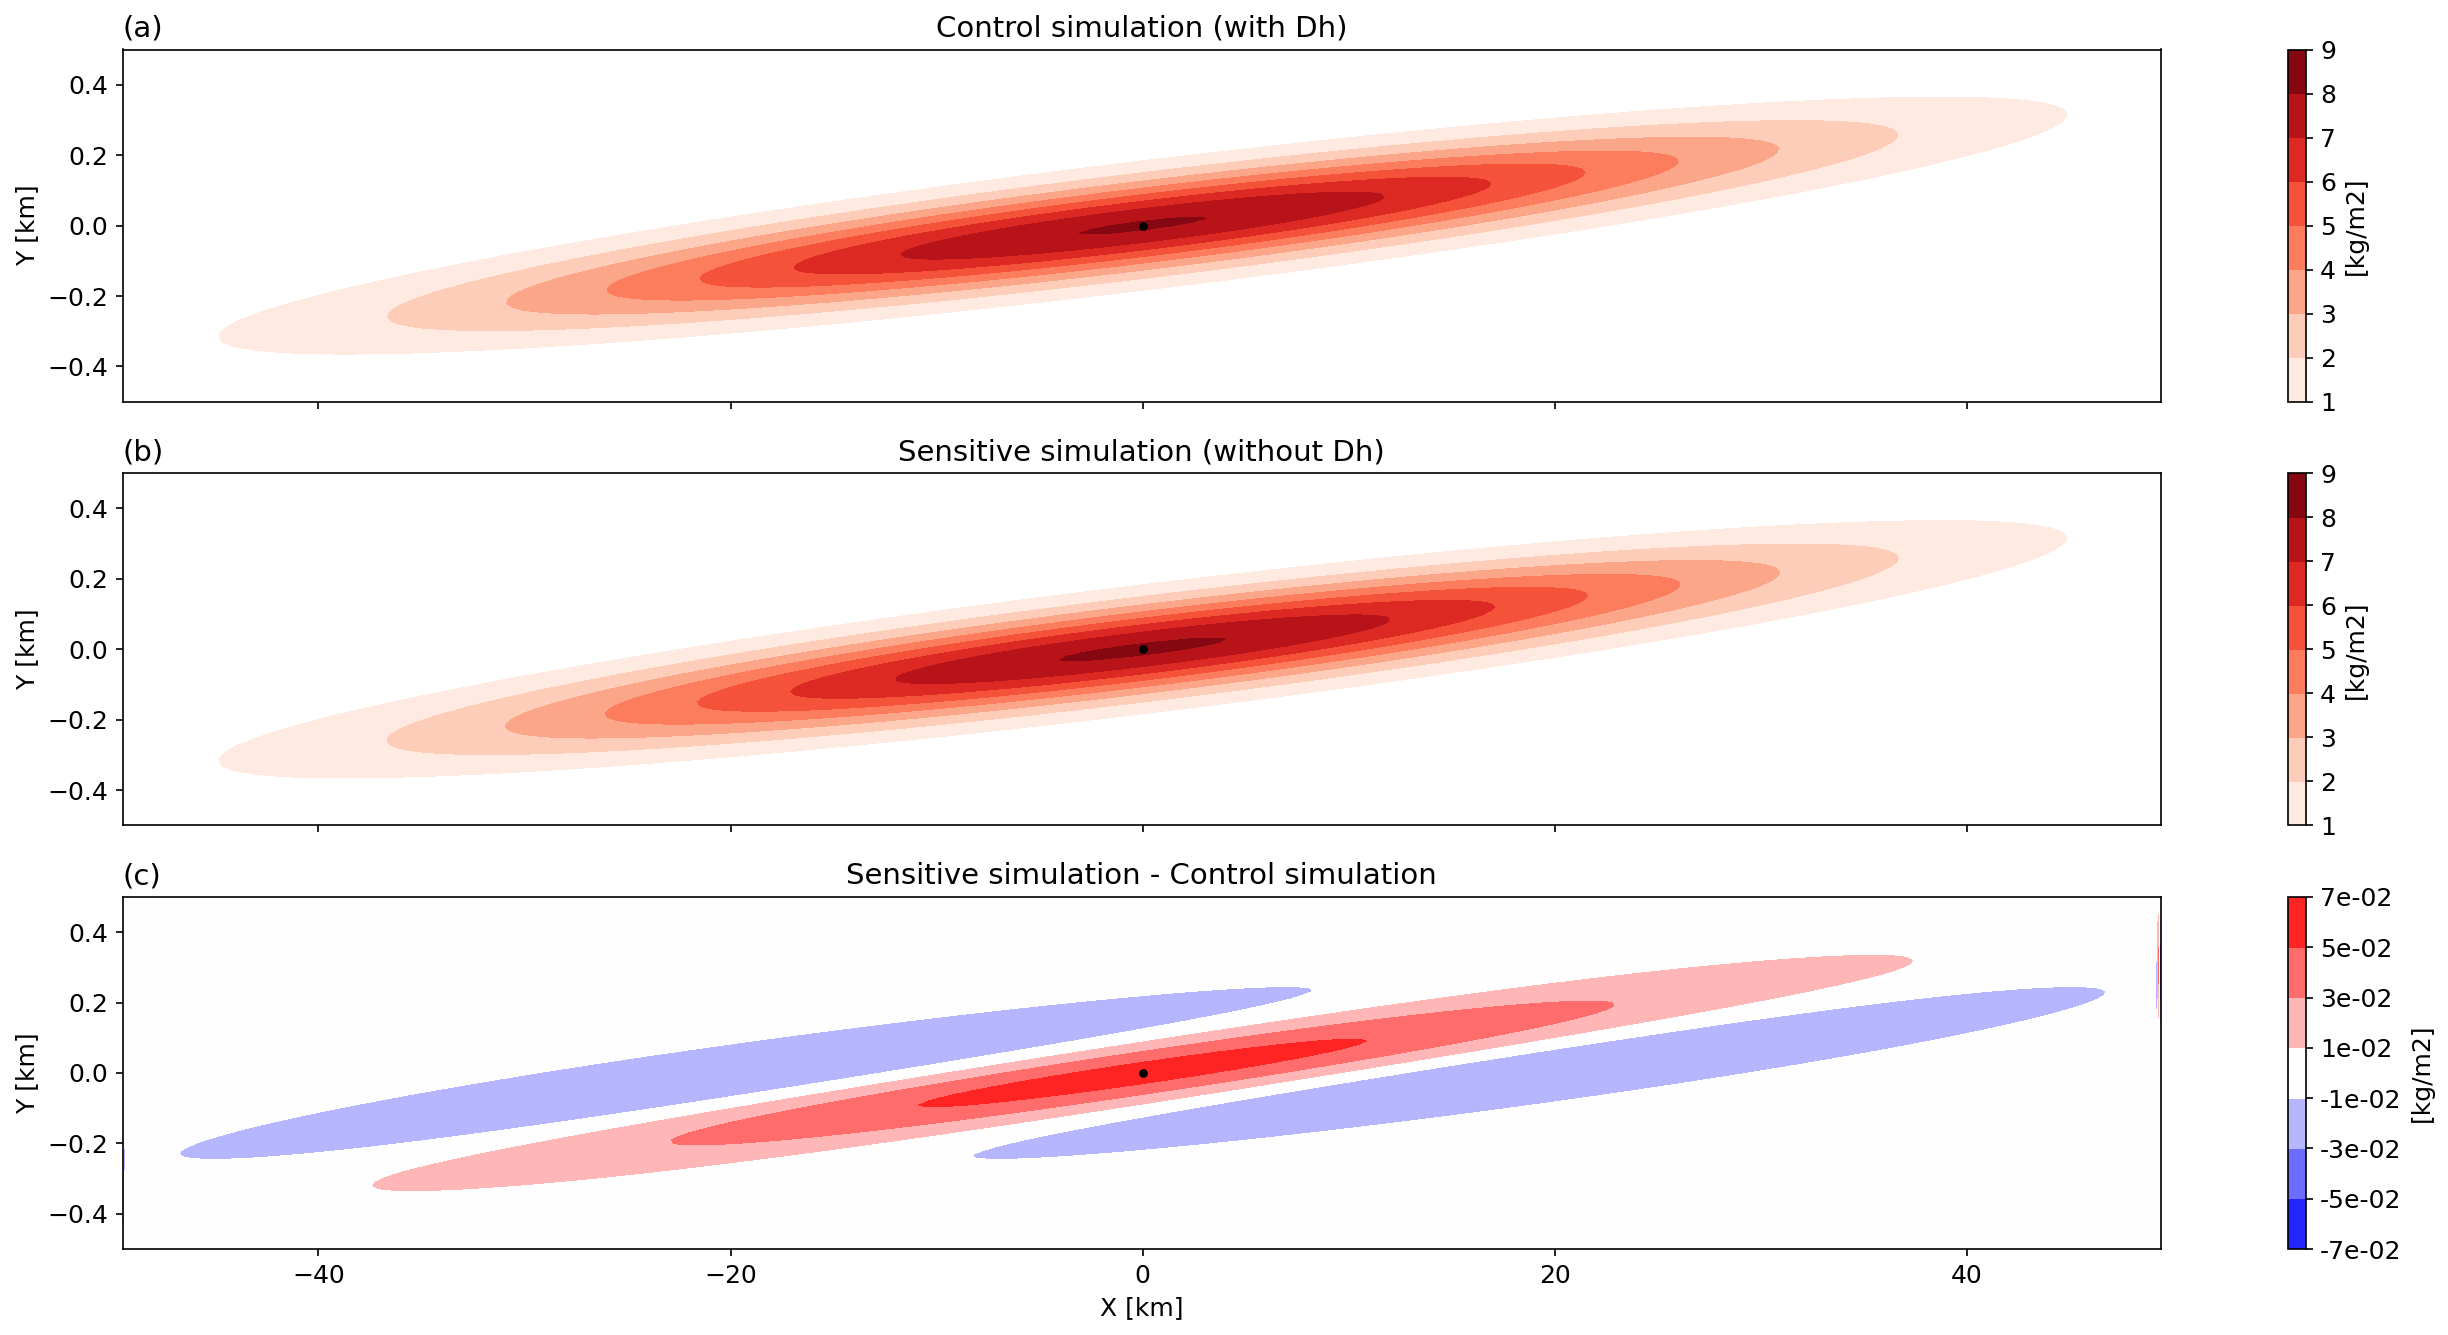

In [30]:
# plot 2-D model

fig = plt.figure(figsize=(18,9), dpi=150)

levs = np.arange(1,10,1)

# (1)
ax1 = plt.subplot(3,1,1)
ax1_contours = ax1.contourf(X[5:-5,5:-5]/1000, Y[5:-5,5:-5]/1000, Concnt1[5:-5,5:-5], \
                        levs, cmap='Reds')


ax1.plot(0, 0, 'k.')
ax1.plot(0, 0, 'k.')
# plt.plot(xnew/1000,ynew/1000,'b--')

cbar1 = plt.colorbar(ax1_contours, ax=ax1)
cbar1.ax.set_ylabel('[kg/m2]',fontsize=12)
cbar1.ax.tick_params(labelsize=12)

ax1.set_title('(a)',fontsize=14,loc='left')
ax1.set_title('Control simulation (with Dh)',fontsize=14)

# ax1.set_xlim([-80,80])
ax1.set_ylim([-0.5,0.5])

# ax1.set_xticks(fontsize=12)
# ax1.set_yticks(fontsize=12)
# ax1.set_xticklabels(xlabels, fontsize=12)
ax1.tick_params(axis='x', labelbottom=False, labelsize=12)
ax1.tick_params(axis='y', labelsize=12)

ax1.set_ylabel('Y [km]',fontsize=12)


# # (2) plot guassian
ax2 = plt.subplot(3,1,2)
ax2_contours = ax2.contourf(X[5:-5,5:-5]/1000, Y[5:-5,5:-5]/1000, Concnt3[5:-5,5:-5], \
                        levs, cmap='Reds')

ax2.plot(0, 0, 'k.')
ax2.plot(0, 0, 'k.')

cbar2 = plt.colorbar(ax2_contours, ax=ax2)
cbar2.ax.set_ylabel('[kg/m2]',fontsize=12)
cbar2.ax.tick_params(labelsize=12)

ax2.set_title('(b)',fontsize=14,loc='left')
ax2.set_title('Sensitive simulation (without Dh)',fontsize=14)

# ax2.set_xlim([-80,80])
ax2.set_ylim([-0.5,0.5])

ax2.tick_params(axis='x', labelbottom=False, labelsize=12)
ax2.tick_params(axis='y', labelsize=12)

ax2.set_ylabel('Y [km]',fontsize=12)


# # (3) plot the concentration difference
C_diff = Concnt3[5:-5,5:-5] - Concnt1[5:-5,5:-5]

levs = np.arange(-7e-2,7e-2,2e-2)

ax3 = plt.subplot(3,1,3)
ax3_contours = ax3.contourf(X[5:-5,5:-5]/1000, Y[5:-5,5:-5]/1000, C_diff, \
                        levs, cmap='bwr')

ax3.plot(0, 0, 'k.')
ax3.plot(0, 0, 'k.')

cbar3 = plt.colorbar(ax3_contours, ax=ax3, format='%.0e')
cbar3.ax.set_ylabel('[kg/m2]',fontsize=12)
# cbar3.ax.set_yticklabels(['{:.9f}'.format(x) for x in levs])
cbar3.ax.tick_params(labelsize=12)

ax3.set_title('(c)',fontsize=14,loc='left')
ax3.set_title('Sensitive simulation - Control simulation',fontsize=14)

# ax3.set_xlim([-80,80])
ax3.set_ylim([-0.5,0.5])

ax3.tick_params(axis='x', labelsize=12);
ax3.tick_params(axis='y', labelsize=12);

ax3.set_ylabel('Y [km]',fontsize=12);
ax3.set_xlabel('X [km]',fontsize=12);

plt.tight_layout()

In [20]:
np.max(Concnt1), np.max(Concnt3), 100*(np.max(Concnt3)-np.max(Concnt1))/np.max(Concnt1)

(8.079767181090755, 8.137790607327085, 0.7181324032717623)

In [107]:
mass1, mass3, (mass3-mass1)/mass1*100

NameError: name 'mass1' is not defined

In [ ]:
mass11/mass1